In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import torch
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import accuracy_score
from rouge import Rouge

import json
import os
import nltk

from tqdm import tqdm


In [745]:
a = ('s', 5)

In [748]:
a[0] = 5

TypeError: 'tuple' object does not support item assignment

In [749]:
a = set()

In [583]:
python.version__

NameError: name 'python' is not defined

In [754]:
a = [1,2]
b= [3,4]

In [750]:
a.add(5)

In [757]:
a.concat(b)

AttributeError: 'list' object has no attribute 'concat'

In [753]:
a.append(5)

AttributeError: 'set' object has no attribute 'append'

In [2]:
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.wsd import lesk
for ss in wn.synsets('bank'):
    print(ss, ss.definition())

Synset('bank.n.01') sloping land (especially the slope beside a body of water)
Synset('depository_financial_institution.n.01') a financial institution that accepts deposits and channels the money into lending activities
Synset('bank.n.03') a long ridge or pile
Synset('bank.n.04') an arrangement of similar objects in a row or in tiers
Synset('bank.n.05') a supply or stock held in reserve for future use (especially in emergencies)
Synset('bank.n.06') the funds held by a gambling house or the dealer in some gambling games
Synset('bank.n.07') a slope in the turn of a road or track; the outside is higher than the inside in order to reduce the effects of centrifugal force
Synset('savings_bank.n.02') a container (usually with a slot in the top) for keeping money at home
Synset('bank.n.09') a building in which the business of banking transacted
Synset('bank.n.10') a flight maneuver; aircraft tips laterally about its longitudinal axis (especially in turning)
Synset('bank.v.01') tip laterally
Sy

In [3]:
PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/"
data = pd.read_csv(PATH+'trial.data.v1.txt', delimiter='\t', header=None)
keys = pd.read_csv(PATH+'trial.gold.v1.txt', delimiter='\t', header=None)
df = pd.concat([data, keys],axis=1)
df.columns = ['keyword', 'context', 'img1', 'img2', 'img3', 'img4', 'img5', 'img6', 'img7', 'img8', 'img9', 'img10', 'gold_key']
df.head()


keyword             context           img1          img2           img3  \
0  andromeda      andromeda tree  image.155.jpg  image.68.jpg    image.9.jpg   
1     angora         angora city    image.5.jpg  image.52.jpg   image.96.jpg   
2   anteater  marsupial anteater  image.147.jpg  image.16.jpg  image.107.jpg   
3       bank        bank erosion  image.104.jpg  image.64.jpg  image.108.jpg   
4     router     internet router  image.127.jpg   image.0.jpg   image.20.jpg   

            img4           img5          img6           img7           img8  \
0   image.72.jpg  image.158.jpg  image.86.jpg    image.7.jpg  image.132.jpg   
1   image.70.jpg   image.46.jpg  image.91.jpg   image.76.jpg  image.139.jpg   
2  image.135.jpg   image.93.jpg  image.59.jpg   image.88.png  image.131.jpg   
3   image.80.jpg   image.21.jpg  image.99.jpg  image.117.jpg  image.146.jpg   
4   image.18.jpg  image.112.jpg  image.97.jpg   image.24.jpg    image.1.jpg   

           img9          img10       gold_key  
0  image.36.jpg   image.27.jpg   image.86.jpg  
1  image.14.jpg  image.115.jpg   image.70.jpg  
2  image.89.jpg  image.121.jpg  image.107.jpg  
3  image.87.jpg   image.34.jpg   image.64.jpg  
4  image.56.jpg   image.26.jpg   image.18.jpg

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

In [20]:
generated_text_dict = {}

In [27]:
for row in tqdm(range(len(df))):
    for img in range(1,11):
        selected_col = df.iloc[row][f'img{img}']
        
        if selected_col in generated_text_dict.keys():
            pred = generated_text_dict[selected_col]
            
        
        else:
            IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1/"
            IMAGE_PATH_EACH = IMAGE_PATH + selected_col
            
            plot_img = Image.open(IMAGE_PATH_EACH)
            if plot_img.mode != "RGB":          #add this thing
                plot_img = plot_img.convert(mode="RGB")
                
                
            pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
            pixel_values = pixel_values.to(device)  
            gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
            output_ids = model.generate(pixel_values, **gen_kwargs)
            pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
            
            generated_text_dict[selected_col] = pred[0]
            
        

100%|██████████| 16/16 [02:09<00:00,  8.08s/it]


## Writing json file

In [28]:
filename = 'test-image-description.json'
with open(filename, 'w') as f:
    json.dump(generated_text_dict, f, sort_keys=True, indent=4)

## Reading photos and transform to text from Arysse

In [33]:
arysse_generated_text= {}

In [34]:

for row in tqdm(range(len(df))):

    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
    IMAGE_PATH_EACH = IMAGE_PATH + f"image1_{row}.png"
    # print(IMAGE_PATH_EACH)
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    if plot_img.mode != "RGB":          #add this thing
        plot_img = plot_img.convert(mode="RGB")
        
        
    pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)  
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    output_ids = model.generate(pixel_values, **gen_kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    arysse_generated_text[f"image1_{row}.png"] = pred[0]

100%|██████████| 16/16 [00:20<00:00,  1.29s/it]


In [35]:
filename = 'arysse-test-image-description.json'
with open(filename, 'w') as f:
    json.dump(arysse_generated_text, f, sort_keys=True, indent=4)

---

# Compute text similarity

In [234]:
similarity_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [227]:
sentences = [
    "I am going crazy",
    "Oops, I did it again",
    "Don't let me be the last to know",
    "You are getting on my last nerves"]

In [228]:
output = similarity_model.encode(sentences)
cosine_similarity(
    [output[0]],
    output[1:]
)

array([[0.13393424, 0.23756652, 0.2533574 ]], dtype=float32)

In [50]:
for i in arysse_generated_text.keys():
    print(arysse_generated_text[i])

a tree that has a bunch of leaves on it 
a large building with a lot of trees 
an animal that is laying down on the ground 
a pile of sand on the beach 
a black and white photo of an electronic device 
a hand holding a small device in front of a wall 
a man holding a baseball bat on top of a tennis court 
a subway train that is stopped at a platform 
a black and white photo of a white object 
a painting of a man riding a horse 
a bowl of eggs on top of a white plate 
a woman on a grassy field with a frisbee 
a young boy dressed in a pirate costume 
a collage of photos of a man in a suit and tie 
a beautiful young woman posing in front of a wall 
a plate of food with vegetables and fruit 


In [484]:
def map_correct_label(dataframe):
    """Map the dataframe.gold_key value with the matching index of the given 10 candidate photos

    Args:
        dataframe (pd.DataFrame): the dataframe from the folder 
        containing 10 candidates photos and gold key

    Returns:
        list of integer: the matching index from gold key to 10 candidate photos
    """

    mapped_class = []
    for row in range(len(dataframe)):
        value_list = []
        for num in range(1 ,11): #given there are 10 candidate photos in each reow
            col = f"img{num}"
            value_list.append(dataframe[col].iloc[row]) #return =["1.png", "2.png"]
            key_value = dataframe.gold_key.iloc[row] #return = "1.png"
        output = value_list.index(key_value) #return 0
        mapped_class.append(output) #return [0]

        
    return mapped_class
    

In [120]:
df['mapped_label'] = map_correct_label(df)
df.head()

keyword             context           img1          img2           img3  \
0  andromeda      andromeda tree  image.155.jpg  image.68.jpg    image.9.jpg   
1     angora         angora city    image.5.jpg  image.52.jpg   image.96.jpg   
2   anteater  marsupial anteater  image.147.jpg  image.16.jpg  image.107.jpg   
3       bank        bank erosion  image.104.jpg  image.64.jpg  image.108.jpg   
4     router     internet router  image.127.jpg   image.0.jpg   image.20.jpg   

            img4           img5          img6           img7           img8  \
0   image.72.jpg  image.158.jpg  image.86.jpg    image.7.jpg  image.132.jpg   
1   image.70.jpg   image.46.jpg  image.91.jpg   image.76.jpg  image.139.jpg   
2  image.135.jpg   image.93.jpg  image.59.jpg   image.88.png  image.131.jpg   
3   image.80.jpg   image.21.jpg  image.99.jpg  image.117.jpg  image.146.jpg   
4   image.18.jpg  image.112.jpg  image.97.jpg   image.24.jpg    image.1.jpg   

           img9          img10       gold_key  mapped_label  
0  image.36.jpg   image.27.jpg   image.86.jpg             5  
1  image.14.jpg  image.115.jpg   image.70.jpg             3  
2  image.89.jpg  image.121.jpg  image.107.jpg             2  
3  image.87.jpg   image.34.jpg   image.64.jpg             1  
4  image.56.jpg   image.26.jpg   image.18.jpg             3

# MAIN CLASSIFICAITON

In [235]:
score_matrix = [] #to keep track of similarity score shape = (row, number of photos)
candidate_description_list_all = [] #to keep track of matching generated description
for img_idx, dict_key in enumerate(arysse_generated_text.keys()):
    generated_context_desc = arysse_generated_text[dict_key] #given key, return the generate description
    candidate_description_list= [generated_context_desc] #append to the list
    for candidate_idx in range(1, 11): # as each row has the 10 candidate photos
        selected_img= df.iloc[img_idx, candidate_idx+1]
        candidate_desc = generated_text_dict[selected_img]  #given key, return the generate description but from another dictionary
        candidate_description_list.append(candidate_desc)
        
        
    candidate_description_list_all.append(candidate_description_list) 
    similarity_score = similarity_model.encode(candidate_description_list)
    score = cosine_similarity( [similarity_score[0]], similarity_score[1:]).tolist()[0]
    score_matrix.append(score)


In [444]:
print(np.argmax(np.array(score_matrix), 1) ) #y predicted classes
print(np.array(df.mapped_label.tolist())) #y true classes

[7 3 1 4 3 6 9 5 9 5 2 1 1 9 9 9]
[5 3 2 1 3 2 9 5 9 7 2 5 6 9 1 2]


In [873]:
torch.tensor(score_matrix[0]).softmax(dim= -1)

tensor([0.0865, 0.1101, 0.0874, 0.1108, 0.1103, 0.0981, 0.0688, 0.1224, 0.0888,
        0.1167])

In [445]:
print(np.sum(np.argmax(np.array(score_matrix), 1) ==  np.array(df.mapped_label.tolist())))

7


In [485]:
7/16

0.4375

[0.4584035277366638, 0.48541414737701416, 0.6869735717773438, 0.6885348558425903, 0.20327365398406982, 0.05539536476135254, 0.26523900032043457, 0.38185566663742065, 0.26055431365966797, 0.8920146822929382]


Text(0.5, 1.0, 'a plate of food with vegetables and fruit ')

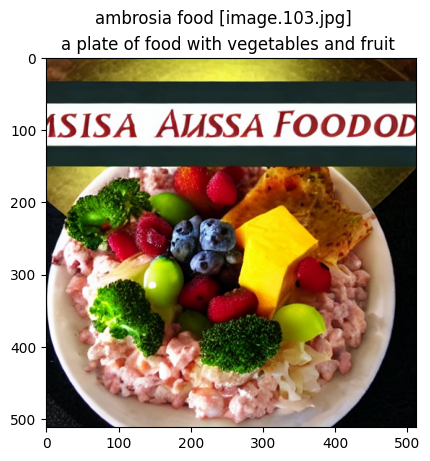

In [859]:
row = 15
ARYSSE_PHOTO_PAHT = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
SELECTED_KEY_PHOTO_PAHT = ARYSSE_PHOTO_PAHT + f"image1_{row}.png"

print(score_matrix[row])

plot_img = Image.open(SELECTED_KEY_PHOTO_PAHT)
plt.imshow(plot_img)
plt.suptitle(df.iloc[row].context + f" [{df.iloc[row].gold_key}]")
plt.title(arysse_generated_text[f"image1_{row}.png"])



In [855]:
candidate_description_list_all[15]

['a plate of food with vegetables and fruit ',
 'a green fire hydrant in the middle of a grassy area ',
 'a pile of green apples sitting on top of each other ',
 'a bowl filled with fruit and nuts on top of a table ',
 'a bowl of soup is sitting on a table ',
 'a man holding a glass of red wine ',
 'a black and white bird is flying through the air ',
 'a close up picture of a red and white flower ',
 'a large green field with a bunch of green plants in it ',
 'a row of wooden barrels filled with barrels ',
 'a variety of fruits and vegetables on a table ']

In [361]:
a = 'a tree that has a bunch of leaves on it'
b_0 = 'a flower arrangement in a flower pot in a garden '
b_1 = 'a tree with a sky background '
b_2 =  'a large green field with a bunch of green plants in it '

In [443]:
rouge_score_0 = rouge.get_scores(b_0, a )[0]['rouge-1']['r']
rouge_score_1 = rouge.get_scores(b_1, a )[0]['rouge-1']['r']
rouge_score_2 = rouge.get_scores(b_2, a )[0]['rouge-1']['r']

print(rouge_score_0, rouge_score_1, rouge_score_2)    

0.1111111111111111 0.2222222222222222 0.4444444444444444


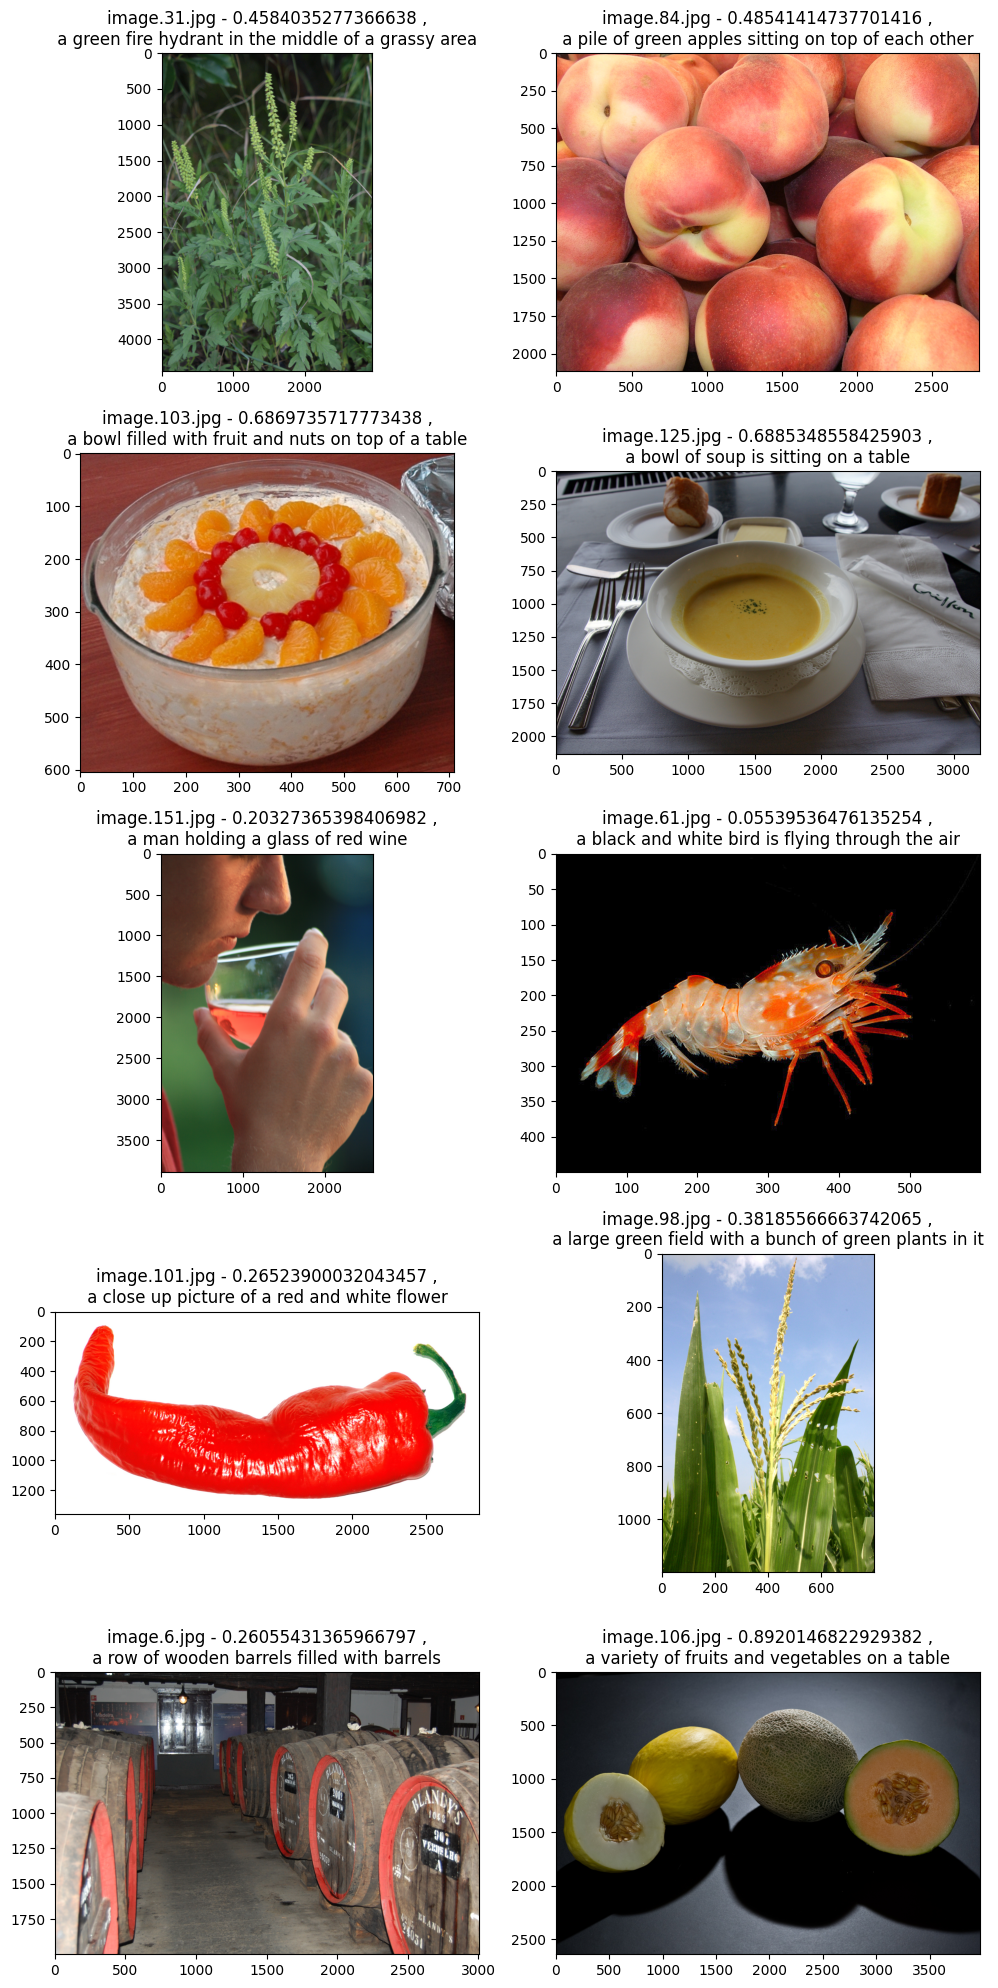

In [860]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (10,20))

for img in range(1,11):
    selected_col = df.iloc[row][f'img{img}']
    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1/"
    IMAGE_PATH_EACH = IMAGE_PATH + selected_col
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    axes.flatten()[img-1].imshow(plot_img)
    axes.flatten()[img-1].set_title(f"{selected_col} - {score_matrix[row][img-1]} ,\n {generated_text_dict[selected_col]}")
    plt.tight_layout()

<AxesSubplot: >

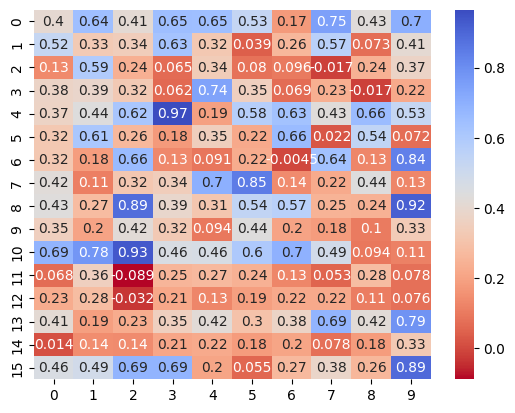

In [519]:

sns.heatmap(score_matrix, annot=True , cmap = "coolwarm_r")


In [528]:
new_df = df.copy(deep= True)
new_df['predicted_class'] = np.argmax(np.array(score_matrix), 1)
new_df.head()

keyword             context           img1          img2           img3  \
0  andromeda      andromeda tree  image.155.jpg  image.68.jpg    image.9.jpg   
1     angora         angora city    image.5.jpg  image.52.jpg   image.96.jpg   
2   anteater  marsupial anteater  image.147.jpg  image.16.jpg  image.107.jpg   
3       bank        bank erosion  image.104.jpg  image.64.jpg  image.108.jpg   
4     router     internet router  image.127.jpg   image.0.jpg   image.20.jpg   

            img4           img5          img6           img7           img8  \
0   image.72.jpg  image.158.jpg  image.86.jpg    image.7.jpg  image.132.jpg   
1   image.70.jpg   image.46.jpg  image.91.jpg   image.76.jpg  image.139.jpg   
2  image.135.jpg   image.93.jpg  image.59.jpg   image.88.png  image.131.jpg   
3   image.80.jpg   image.21.jpg  image.99.jpg  image.117.jpg  image.146.jpg   
4   image.18.jpg  image.112.jpg  image.97.jpg   image.24.jpg    image.1.jpg   

           img9          img10       gold_key  mapped_label  predicted_class  
0  image.36.jpg   image.27.jpg   image.86.jpg             5                7  
1  image.14.jpg  image.115.jpg   image.70.jpg             3                3  
2  image.89.jpg  image.121.jpg  image.107.jpg             2                1  
3  image.87.jpg   image.34.jpg   image.64.jpg             1                4  
4  image.56.jpg   image.26.jpg   image.18.jpg             3                3

In [613]:
new_df[new_df.mapped_label == new_df.predicted_class]

keyword                        context           img1  \
1           angora                    angora city    image.5.jpg   
4           router                internet router  image.127.jpg   
6            swing                      swing hit   image.51.jpg   
7             tube                    london tube  image.105.jpg   
8            venus                  venus surface   image.60.jpg   
10           white                     white yolk  image.130.jpg   
13  administration  administration prime minister   image.39.jpg   

             img2           img3           img4           img5          img6  \
1    image.52.jpg   image.96.jpg   image.70.jpg   image.46.jpg  image.91.jpg   
4     image.0.jpg   image.20.jpg   image.18.jpg  image.112.jpg  image.97.jpg   
6   image.141.jpg   image.11.jpg   image.77.jpg   image.95.jpg  image.33.jpg   
7   image.129.jpg   image.41.jpg   image.43.jpg  image.102.jpg  image.28.jpg   
8    image.37.jpg   image.83.jpg   image.94.jpg   image.17.jpg  image.29.jpg   
10  image.154.jpg   image.71.jpg   image.45.jpg  image.136.jpg  image.42.jpg   
13  image.109.jpg  image.119.jpg  image.153.jpg   image.90.jpg  image.49.jpg   

            img7           img8           img9          img10       gold_key  \
1   image.76.jpg  image.139.jpg   image.14.jpg  image.115.jpg   image.70.jpg   
4   image.24.jpg    image.1.jpg   image.56.jpg   image.26.jpg   image.18.jpg   
6   image.65.jpg  image.113.jpg   image.53.jpg   image.54.jpg   image.54.jpg   
7   image.79.jpg  image.138.jpg   image.12.jpg   image.40.jpg   image.28.jpg   
8   image.32.jpg  image.137.jpg    image.8.jpg  image.124.jpg  image.124.jpg   
10   image.4.jpg   image.38.jpg  image.143.jpg    image.3.jpg   image.71.jpg   
13  image.75.jpg   image.15.jpg  image.150.jpg  image.149.jpg  image.149.jpg   

    mapped_label  predicted_class  
1              3                3  
4              3                3  
6              9                9  
7              5                5  
8              9                9  
10             2                2  
13             9                9

In [874]:
new_df


keyword                        context           img1  \
0        andromeda                 andromeda tree  image.155.jpg   
1           angora                    angora city    image.5.jpg   
2         anteater             marsupial anteater  image.147.jpg   
3             bank                   bank erosion  image.104.jpg   
4           router                internet router  image.127.jpg   
5            stick                   centre stick  image.100.jpg   
6            swing                      swing hit   image.51.jpg   
7             tube                    london tube  image.105.jpg   
8            venus                  venus surface   image.60.jpg   
9            wheel                 breaking wheel  image.111.jpg   
10           white                     white yolk  image.130.jpg   
11      acrobatics           acrobatics maneuvers  image.120.jpg   
12          adalia                 biology adalia   image.44.jpg   
13  administration  administration prime minister   image.39.jpg   
14           amber                   amber bijoux   image.10.jpg   
15        ambrosia                  ambrosia food   image.31.jpg   

             img2           img3           img4           img5           img6  \
0    image.68.jpg    image.9.jpg   image.72.jpg  image.158.jpg   image.86.jpg   
1    image.52.jpg   image.96.jpg   image.70.jpg   image.46.jpg   image.91.jpg   
2    image.16.jpg  image.107.jpg  image.135.jpg   image.93.jpg   image.59.jpg   
3    image.64.jpg  image.108.jpg   image.80.jpg   image.21.jpg   image.99.jpg   
4     image.0.jpg   image.20.jpg   image.18.jpg  image.112.jpg   image.97.jpg   
5    image.62.jpg  image.156.jpg   image.78.jpg  image.122.jpg   image.81.jpg   
6   image.141.jpg   image.11.jpg   image.77.jpg   image.95.jpg   image.33.jpg   
7   image.129.jpg   image.41.jpg   image.43.jpg  image.102.jpg   image.28.jpg   
8    image.37.jpg   image.83.jpg   image.94.jpg   image.17.jpg   image.29.jpg   
9    image.69.jpg   image.82.jpg   image.73.jpg   image.74.jpg   image.48.jpg   
10  image.154.jpg   image.71.jpg   image.45.jpg  image.136.jpg   image.42.jpg   
11  image.133.jpg   image.58.jpg  image.126.jpg   image.57.jpg  image.134.jpg   
12    image.2.jpg   image.22.jpg  image.152.jpg   image.66.jpg  image.116.jpg   
13  image.109.jpg  image.119.jpg  image.153.jpg   image.90.jpg   image.49.jpg   
14   image.85.jpg  image.128.jpg  image.159.jpg  image.142.jpg  image.144.jpg   
15   image.84.jpg  image.103.jpg  image.125.jpg  image.151.jpg   image.61.jpg   

             img7           img8           img9          img10       gold_key  \
0     image.7.jpg  image.132.jpg   image.36.jpg   image.27.jpg   image.86.jpg   
1    image.76.jpg  image.139.jpg   image.14.jpg  image.115.jpg   image.70.jpg   
2    image.88.png  image.131.jpg   image.89.jpg  image.121.jpg  image.107.jpg   
3   image.117.jpg  image.146.jpg   image.87.jpg   image.34.jpg   image.64.jpg   
4    image.24.jpg    image.1.jpg   image.56.jpg   image.26.jpg   image.18.jpg   
5   image.148.jpg  image.114.jpg  image.123.jpg   image.55.jpg  image.156.jpg   
6    image.65.jpg  image.113.jpg   image.53.jpg   image.54.jpg   image.54.jpg   
7    image.79.jpg  image.138.jpg   image.12.jpg   image.40.jpg   image.28.jpg   
8    image.32.jpg  image.137.jpg    image.8.jpg  image.124.jpg  image.124.jpg   
9   image.140.jpg  image.118.jpg   image.50.jpg  image.157.jpg  image.118.jpg   
10    image.4.jpg   image.38.jpg  image.143.jpg    image.3.jpg   image.71.jpg   
11   image.67.jpg   image.30.jpg   image.19.jpg   image.13.jpg  image.134.jpg   
12   image.25.jpg   image.47.jpg  image.145.jpg  image.110.jpg   image.25.jpg   
13   image.75.jpg   image.15.jpg  image.150.jpg  image.149.jpg  image.149.jpg   
14   image.35.jpg   image.23.jpg   image.92.jpg   image.63.jpg   image.85.jpg   
15  image.101.jpg   image.98.jpg    image.6.jpg  image.106.jpg  image.103.jpg   

    mapped_label  predicted_class  
0              5                7  
1              3          

In [551]:
wrong_classes_df

keyword               context           img1           img2  \
0    andromeda        andromeda tree  image.155.jpg   image.68.jpg   
2     anteater    marsupial anteater  image.147.jpg   image.16.jpg   
3         bank          bank erosion  image.104.jpg   image.64.jpg   
5        stick          centre stick  image.100.jpg   image.62.jpg   
9        wheel        breaking wheel  image.111.jpg   image.69.jpg   
11  acrobatics  acrobatics maneuvers  image.120.jpg  image.133.jpg   
12      adalia        biology adalia   image.44.jpg    image.2.jpg   
14       amber          amber bijoux   image.10.jpg   image.85.jpg   
15    ambrosia         ambrosia food   image.31.jpg   image.84.jpg   

             img3           img4           img5           img6           img7  \
0     image.9.jpg   image.72.jpg  image.158.jpg   image.86.jpg    image.7.jpg   
2   image.107.jpg  image.135.jpg   image.93.jpg   image.59.jpg   image.88.png   
3   image.108.jpg   image.80.jpg   image.21.jpg   image.99.jpg  image.117.jpg   
5   image.156.jpg   image.78.jpg  image.122.jpg   image.81.jpg  image.148.jpg   
9    image.82.jpg   image.73.jpg   image.74.jpg   image.48.jpg  image.140.jpg   
11   image.58.jpg  image.126.jpg   image.57.jpg  image.134.jpg   image.67.jpg   
12   image.22.jpg  image.152.jpg   image.66.jpg  image.116.jpg   image.25.jpg   
14  image.128.jpg  image.159.jpg  image.142.jpg  image.144.jpg   image.35.jpg   
15  image.103.jpg  image.125.jpg  image.151.jpg   image.61.jpg  image.101.jpg   

             img8           img9          img10       gold_key  mapped_label  \
0   image.132.jpg   image.36.jpg   image.27.jpg   image.86.jpg             5   
2   image.131.jpg   image.89.jpg  image.121.jpg  image.107.jpg             2   
3   image.146.jpg   image.87.jpg   image.34.jpg   image.64.jpg             1   
5   image.114.jpg  image.123.jpg   image.55.jpg  image.156.jpg             2   
9   image.118.jpg   image.50.jpg  image.157.jpg  image.118.jpg             7   
11   image.30.jpg   image.19.jpg   image.13.jpg  image.134.jpg             5   
12   image.47.jpg  image.145.jpg  image.110.jpg   image.25.jpg             6   
14   image.23.jpg   image.92.jpg   image.63.jpg   image.85.jpg             1   
15   image.98.jpg    image.6.jpg  image.106.jpg  image.103.jpg             2   

    predicted_class  
0                 7  
2                 1  
3                 4  
5                 6  
9                 5  
11                1  
12                1  
14                9  
15                9

In [557]:
top_3_candidate_score_idx

array([9, 4, 3])

[0.13475064933300018, 0.5906554460525513, 0.2374684363603592, 0.0653112530708313, 0.3351011276245117, 0.08011943846940994, 0.09630239009857178, -0.016610421240329742, 0.24151861667633057, 0.37363144755363464]


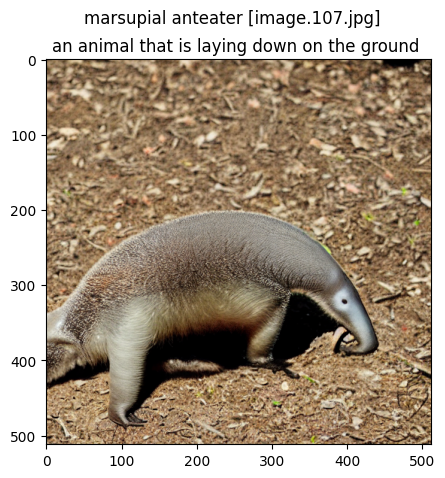

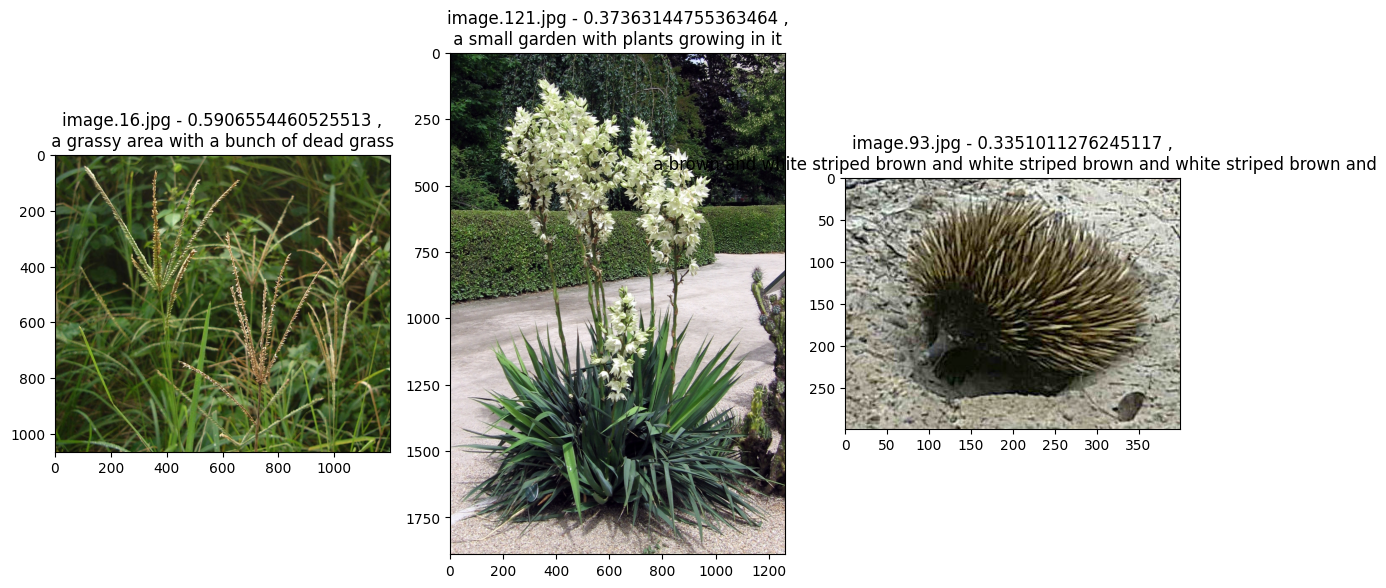

In [570]:
wrong_classes_df =new_df[new_df.mapped_label != new_df.predicted_class ]
row = 2
ARYSSE_PHOTO_PAHT = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
SELECTED_KEY_PHOTO_PAHT = ARYSSE_PHOTO_PAHT + f"image1_{row}.png"

print(score_matrix[row])

plt.figure(figsize = (5,5))
plot_img = Image.open(SELECTED_KEY_PHOTO_PAHT)
plt.imshow(plot_img)
plt.suptitle(df.iloc[row].context + f" [{df.iloc[row].gold_key}]")
plt.title(arysse_generated_text[f"image1_{row}.png"])


fig, axes = plt.subplots(nrows = 1, ncols = 3 ,figsize = (12, 10))

top_3_candidate_score_idx = np.argsort(-np.array(score_matrix[row]))[:3]

for index, img in enumerate(list(top_3_candidate_score_idx)):
    selected_col = df.iloc[row][f'img{img+1}']
    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/semeval-2023-task-1-V-WSD-train-v1/trial_v1/trial_images_v1/"
    IMAGE_PATH_EACH = IMAGE_PATH + selected_col
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    axes.flatten()[index].imshow(plot_img)
    axes.flatten()[index].set_title(f"{selected_col} - {score_matrix[row][img]} ,\n {generated_text_dict[selected_col]}")
    plt.tight_layout()

11 - aerobatic maeuvers - a woman on a grassy field

In [559]:
np.argsort(-np.array(score_matrix[row]))

array([9, 4, 3, 6, 5, 8, 1, 2, 7, 0])

In [586]:
score_matrix[0]

[0.40342557430267334,
 0.6441419124603271,
 0.4131656885147095,
 0.6506786942481995,
 0.6460137367248535,
 0.5290894508361816,
 0.17445673048496246,
 0.7503365874290466,
 0.42970725893974304,
 0.7024884819984436]

In [598]:
list(np.argsort(-np.array(score_matrix[0])))

[7, 9, 3, 4, 1, 5, 8, 2, 0, 6]

In [597]:
row_0 = df.iloc[0][2:12].to_list()

## Save the sorted predicted photos from the similarity score

In [612]:
result_dictionary_1 = {}
for row in range(len(df)):
    order_list_score = list(np.argsort(-np.array(score_matrix[row])))
    photo_name_list = df.iloc[row][2:12].to_list() #column 2- 12 for image1 : image10
    rearranged_photo_name_list = [photo_name_list[order_index] for order_index in order_list_score]
    
    result_dictionary_1[row] = rearranged_photo_name_list
    
    
filename = 'result_dictionary_1.json'
with open(filename, 'w') as f:
    json.dump(result_dictionary_1, f, sort_keys=True, indent=4)   

print(order_list_score)
print(photo_name_list)
print(rearranged_photo_name_list)

        
    

[9, 3, 2, 1, 0, 7, 6, 8, 4, 5]
['image.31.jpg', 'image.84.jpg', 'image.103.jpg', 'image.125.jpg', 'image.151.jpg', 'image.61.jpg', 'image.101.jpg', 'image.98.jpg', 'image.6.jpg', 'image.106.jpg']
['image.106.jpg', 'image.125.jpg', 'image.103.jpg', 'image.84.jpg', 'image.31.jpg', 'image.98.jpg', 'image.101.jpg', 'image.6.jpg', 'image.151.jpg', 'image.61.jpg']


---

# Select only the NOUN from each sentence

In [437]:
new_keys = []
new_keys_join = []
for i in range(11):
    lines = candidate_description_list_all[0][i]
    is_noun = lambda pos: pos[:2] == 'NN'
    # do the nlp stuff
    tokenized = nltk.word_tokenize(lines)
    nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
    new_keys.append(nouns) 
    new_keys_join.append(" ".join(new_keys[i]))

In [491]:
new_keys_join

['plate food vegetables fruit',
 'fire hydrant middle area',
 'pile apples top',
 'bowl fruit nuts top table',
 'bowl soup table',
 'man glass wine',
 'bird air',
 'close picture flower',
 'field bunch plants',
 'row barrels barrels',
 'variety fruits vegetables table']

In [448]:
similarity_score = similarity_model.encode(new_keys_join)
cosine_similarity( [similarity_score[0]], similarity_score[1:])

array([[0.5569906 , 0.7142397 , 0.41985643, 0.7574553 , 0.6823636 ,
        0.6003632 , 0.35612535, 0.72077143, 0.40925527, 0.6936598 ]],
      dtype=float32)

In [492]:
new_keys_join_score_matrix = []

for row in range(len(df)):
    new_keys = []
    new_keys_join = []
    for i in range(11):
        lines = candidate_description_list_all[row][i]
        is_noun = lambda pos: pos[:2] == 'NN'
        # do the nlp stuff
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        new_keys.append(nouns) 
        new_keys_join.append(" ".join(new_keys[i]))
    similarity_score = similarity_model.encode(new_keys_join)
    score = cosine_similarity( [similarity_score[0]], similarity_score[1:]) 
    new_keys_join_score_matrix.append(score)

In [568]:
candidate_description_list_all[2]

['an animal that is laying down on the ground ',
 'a vase filled with flowers on top of a table ',
 'a grassy area with a bunch of dead grass ',
 'a zebra standing on top of a pile of dead birds ',
 'a large brown bear standing on top of a log ',
 'a brown and white striped brown and white striped brown and white striped brown and',
 'a vase filled with yellow flowers on top of a table ',
 'a blue and white sign with a clock on it ',
 'a large brown and white elephant walking through a field ',
 'a bird standing on top of a body of water ',
 'a small garden with plants growing in it ']

In [496]:
new_keys_join

['plate food vegetables fruit',
 'fire hydrant middle area',
 'pile apples top',
 'bowl fruit nuts top table',
 'bowl soup table',
 'man glass wine',
 'bird air',
 'close picture flower',
 'field bunch plants',
 'row barrels barrels',
 'variety fruits vegetables table']

In [493]:
np.array(new_keys_join_score_matrix).shape

(16, 1, 10)

In [464]:
new_keys_join_score_matrix[0][0]

array([0.5569906 , 0.7142397 , 0.41985643, 0.7574553 , 0.6823636 ,
       0.6003632 , 0.35612535, 0.72077143, 0.40925527, 0.6936598 ],
      dtype=float32)

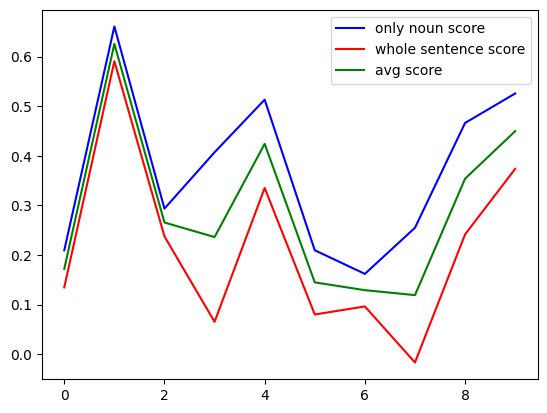

In [567]:
plt.plot(np.arange(10), new_keys_join_score_matrix[2][0] ,c = 'blue', label = 'only noun score' )
plt.plot(np.arange(10), np.array(score_matrix[2] ), c = 'red', label = 'whole sentence score')
plt.plot(np.arange(10),  (new_keys_join_score_matrix[2][0] + np.array(score_matrix[2] )) /2 , c = 'green', 
         label = 'avg score')
plt.legend()

In [468]:
new_keys_join_score_matrix[0][0] + np.array(score_matrix[0]) / 2

array([0.75870341, 1.03631067, 0.62643927, 1.08279464, 1.0053705 ,
       0.86490792, 0.44335372, 1.09593973, 0.6241089 , 1.04490402])

---

# Use AVERAGE of context and key

## Update the Arysses generated keys to contain the 'key' word

In [709]:
for row in tqdm(range(len(df))):

    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
    IMAGE_PATH_EACH = IMAGE_PATH + f"image0_{row}.png"
    # print(IMAGE_PATH_EACH)
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    if plot_img.mode != "RGB":          #add this thing
        plot_img = plot_img.convert(mode="RGB")
        
        
    pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)  
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    output_ids = model.generate(pixel_values, **gen_kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    arysse_generated_text[f"image0_{row}.png"] = pred[0]

100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


In [710]:
filename = 'arysse-test-image-description.json'
with open(filename, 'w') as f:
    json.dump(arysse_generated_text, f, sort_keys=True, indent=4)

## Classification

In [662]:
def classify_function(dataframe, key_dict, cand_dict ):
    score_matrix = [] #to keep track of similarity score shape = (row, number of photos)
    candidate_description_list_all = [] #to keep track of matching generated description
    
    assert len(key_dict) == len(dataframe)
    for img_idx, dict_key in enumerate(key_dict.keys()):
        generated_context_desc = key_dict[dict_key] #given key, return the generate description
        candidate_description_list= [generated_context_desc] #append to the list
        for candidate_idx in range(1, 11): # as each row has the 10 candidate photos
            selected_img= dataframe.iloc[img_idx, candidate_idx+1]
            candidate_desc = cand_dict[selected_img]  #given key, return the generate description but from another dictionary
            candidate_description_list.append(candidate_desc)
        
        
        candidate_description_list_all.append(candidate_description_list) 
        similarity_score = similarity_model.encode(candidate_description_list)
        score = cosine_similarity( [similarity_score[0]], similarity_score[1:]).tolist()[0]
        score_matrix.append(score)
    
    return score_matrix, candidate_description_list_all

def create_df_with_prediction(dataframe, score_matrix):
    new_df = dataframe.copy(deep =True)
    new_df['predicted_class'] = np.argmax(np.array(score_matrix), 1)
    match_count = np.sum(new_df.predicted_class == new_df.mapped_label)
    total_count = len(dataframe)
    accuracy_score = match_count/ total_count
    
    print(f"There are {match_count} matches from {total_count}, = {accuracy_score}")
    
    return new_df, accuracy_score

### Regular Expression Filtering the Aryss' dictionary

In [649]:
dict_0 = dict([(key, value) for key, value in arysse_generated_text.items() if key.startswith("image0")])
dict_1 = dict([(key, value) for key, value in arysse_generated_text.items() if key.startswith("image1")])

In [667]:
score_matrix_1, candidate_description_list_all_1 = classify_function(dataframe=df,
                          key_dict= dict_1,
                          cand_dict = generated_text_dict )
pred_df_1, pred_df_1_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=score_matrix_1)

pred_df_1.head()


There are 7 matches from 16, = 0.4375


keyword             context           img1          img2           img3  \
0  andromeda      andromeda tree  image.155.jpg  image.68.jpg    image.9.jpg   
1     angora         angora city    image.5.jpg  image.52.jpg   image.96.jpg   
2   anteater  marsupial anteater  image.147.jpg  image.16.jpg  image.107.jpg   
3       bank        bank erosion  image.104.jpg  image.64.jpg  image.108.jpg   
4     router     internet router  image.127.jpg   image.0.jpg   image.20.jpg   

            img4           img5          img6           img7           img8  \
0   image.72.jpg  image.158.jpg  image.86.jpg    image.7.jpg  image.132.jpg   
1   image.70.jpg   image.46.jpg  image.91.jpg   image.76.jpg  image.139.jpg   
2  image.135.jpg   image.93.jpg  image.59.jpg   image.88.png  image.131.jpg   
3   image.80.jpg   image.21.jpg  image.99.jpg  image.117.jpg  image.146.jpg   
4   image.18.jpg  image.112.jpg  image.97.jpg   image.24.jpg    image.1.jpg   

           img9          img10       gold_key  mapped_label  predicted_class  
0  image.36.jpg   image.27.jpg   image.86.jpg             5                7  
1  image.14.jpg  image.115.jpg   image.70.jpg             3                3  
2  image.89.jpg  image.121.jpg  image.107.jpg             2                1  
3  image.87.jpg   image.34.jpg   image.64.jpg             1                4  
4  image.56.jpg   image.26.jpg   image.18.jpg             3                3

In [669]:
score_matrix_0, candidate_description_list_all_1 = classify_function(dataframe=df,
                          key_dict= dict_0,
                          cand_dict = generated_text_dict )
pred_df_0, pred_df_0_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=score_matrix_0)

pred_df_0.head()


There are 4 matches from 16, = 0.25


keyword             context           img1          img2           img3  \
0  andromeda      andromeda tree  image.155.jpg  image.68.jpg    image.9.jpg   
1     angora         angora city    image.5.jpg  image.52.jpg   image.96.jpg   
2   anteater  marsupial anteater  image.147.jpg  image.16.jpg  image.107.jpg   
3       bank        bank erosion  image.104.jpg  image.64.jpg  image.108.jpg   
4     router     internet router  image.127.jpg   image.0.jpg   image.20.jpg   

            img4           img5          img6           img7           img8  \
0   image.72.jpg  image.158.jpg  image.86.jpg    image.7.jpg  image.132.jpg   
1   image.70.jpg   image.46.jpg  image.91.jpg   image.76.jpg  image.139.jpg   
2  image.135.jpg   image.93.jpg  image.59.jpg   image.88.png  image.131.jpg   
3   image.80.jpg   image.21.jpg  image.99.jpg  image.117.jpg  image.146.jpg   
4   image.18.jpg  image.112.jpg  image.97.jpg   image.24.jpg    image.1.jpg   

           img9          img10       gold_key  mapped_label  predicted_class  
0  image.36.jpg   image.27.jpg   image.86.jpg             5                7  
1  image.14.jpg  image.115.jpg   image.70.jpg             3                8  
2  image.89.jpg  image.121.jpg  image.107.jpg             2                7  
3  image.87.jpg   image.34.jpg   image.64.jpg             1                9  
4  image.56.jpg   image.26.jpg   image.18.jpg             3                1

In [688]:
average_score_matrix = (np.array(score_matrix_1) + np.array(score_matrix_0)) /2

In [696]:
pred_df_avg, pred_df_avg_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=average_score_matrix)

There are 7 matches from 16, = 0.4375


In [697]:
pred_df_avg[pred_df_avg.predicted_class == pred_df_avg.mapped_label]

keyword                        context           img1  \
4           router                internet router  image.127.jpg   
6            swing                      swing hit   image.51.jpg   
7             tube                    london tube  image.105.jpg   
8            venus                  venus surface   image.60.jpg   
10           white                     white yolk  image.130.jpg   
12          adalia                 biology adalia   image.44.jpg   
13  administration  administration prime minister   image.39.jpg   

             img2           img3           img4           img5           img6  \
4     image.0.jpg   image.20.jpg   image.18.jpg  image.112.jpg   image.97.jpg   
6   image.141.jpg   image.11.jpg   image.77.jpg   image.95.jpg   image.33.jpg   
7   image.129.jpg   image.41.jpg   image.43.jpg  image.102.jpg   image.28.jpg   
8    image.37.jpg   image.83.jpg   image.94.jpg   image.17.jpg   image.29.jpg   
10  image.154.jpg   image.71.jpg   image.45.jpg  image.136.jpg   image.42.jpg   
12    image.2.jpg   image.22.jpg  image.152.jpg   image.66.jpg  image.116.jpg   
13  image.109.jpg  image.119.jpg  image.153.jpg   image.90.jpg   image.49.jpg   

            img7           img8           img9          img10       gold_key  \
4   image.24.jpg    image.1.jpg   image.56.jpg   image.26.jpg   image.18.jpg   
6   image.65.jpg  image.113.jpg   image.53.jpg   image.54.jpg   image.54.jpg   
7   image.79.jpg  image.138.jpg   image.12.jpg   image.40.jpg   image.28.jpg   
8   image.32.jpg  image.137.jpg    image.8.jpg  image.124.jpg  image.124.jpg   
10   image.4.jpg   image.38.jpg  image.143.jpg    image.3.jpg   image.71.jpg   
12  image.25.jpg   image.47.jpg  image.145.jpg  image.110.jpg   image.25.jpg   
13  image.75.jpg   image.15.jpg  image.150.jpg  image.149.jpg  image.149.jpg   

    mapped_label  predicted_class  
4              3                3  
6              9                9  
7              5                5  
8              9                9  
10             2                2  
12             6                6  
13             9                9

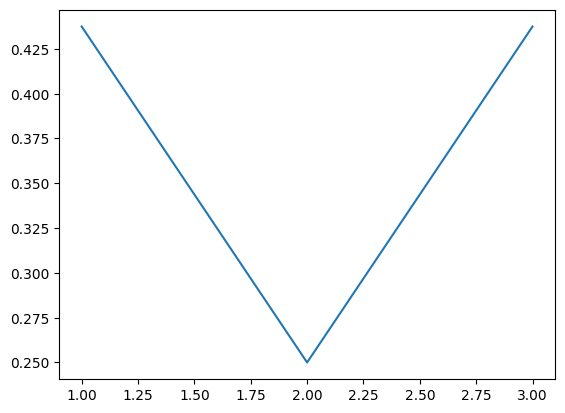

In [705]:
plt.plot([1,2,3], [pred_df_1_acc, pred_df_0_acc,  pred_df_avg_acc])

In [670]:
pred_df_0[pred_df_0.predicted_class == pred_df_0.mapped_label]

keyword               context           img1           img2  \
7         tube           london tube  image.105.jpg  image.129.jpg   
8        venus         venus surface   image.60.jpg   image.37.jpg   
11  acrobatics  acrobatics maneuvers  image.120.jpg  image.133.jpg   
12      adalia        biology adalia   image.44.jpg    image.2.jpg   

            img3           img4           img5           img6          img7  \
7   image.41.jpg   image.43.jpg  image.102.jpg   image.28.jpg  image.79.jpg   
8   image.83.jpg   image.94.jpg   image.17.jpg   image.29.jpg  image.32.jpg   
11  image.58.jpg  image.126.jpg   image.57.jpg  image.134.jpg  image.67.jpg   
12  image.22.jpg  image.152.jpg   image.66.jpg  image.116.jpg  image.25.jpg   

             img8           img9          img10       gold_key  mapped_label  \
7   image.138.jpg   image.12.jpg   image.40.jpg   image.28.jpg             5   
8   image.137.jpg    image.8.jpg  image.124.jpg  image.124.jpg             9   
11   image.30.jpg   image.19.jpg   image.13.jpg  image.134.jpg             5   
12   image.47.jpg  image.145.jpg  image.110.jpg   image.25.jpg             6   

    predicted_class  
7                 5  
8                 9  
11                5  
12                6

In [706]:
print(pred_df_1[pred_df_1.predicted_class == pred_df_1.mapped_label].index)
print(pred_df_0[pred_df_0.predicted_class == pred_df_0.mapped_label].index)
print(pred_df_avg[pred_df_avg.predicted_class == pred_df_avg.mapped_label].index)

Int64Index([1, 4, 6, 7, 8, 10, 13], dtype='int64')
Int64Index([7, 8, 11, 12], dtype='int64')
Int64Index([4, 6, 7, 8, 10, 12, 13], dtype='int64')


---

# Use SEED42

In [711]:
seed = 42
for row in tqdm(range(len(df))):

    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
    IMAGE_PATH_EACH = IMAGE_PATH + f"image_of_row_{row}_seed_{seed}.png"
    # print(IMAGE_PATH_EACH)
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    if plot_img.mode != "RGB":          #add this thing
        plot_img = plot_img.convert(mode="RGB")
        
        
    pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)  
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    output_ids = model.generate(pixel_values, **gen_kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    arysse_generated_text[f"image_of_row_{row}_seed_{seed}.png"] = pred[0]
    
filename = 'arysse-test-image-description.json'
with open(filename, 'w') as f:
    json.dump(arysse_generated_text, f, sort_keys=True, indent=4)

100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


In [714]:
dict_42 = dict([(key, value) for key, value in arysse_generated_text.items() if key.endswith(f"seed_{seed}.png")])

In [729]:
score_matrix_42, candidate_description_list_all_42 = classify_function(dataframe=df,
                          key_dict= dict_42,
                          cand_dict = generated_text_dict )
pred_df_42, pred_df_42_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=score_matrix_42)


There are 5 matches from 16, = 0.3125


In [730]:
print(pred_df_1[pred_df_1.predicted_class == pred_df_1.mapped_label].index)
print(pred_df_0[pred_df_0.predicted_class == pred_df_0.mapped_label].index)
print(pred_df_avg[pred_df_avg.predicted_class == pred_df_avg.mapped_label].index)
print(pred_df_42[pred_df_42.predicted_class == pred_df_42.mapped_label].index)

Int64Index([1, 4, 6, 7, 8, 10, 13], dtype='int64')
Int64Index([7, 8, 11, 12], dtype='int64')
Int64Index([1, 6, 7, 8, 10, 12, 13], dtype='int64')
Int64Index([1, 6, 7, 8, 10], dtype='int64')


In [732]:
average_score_matrix = (np.array(score_matrix_1) + 
                        np.array(score_matrix_42) + 
                        np.array(score_matrix_0)) /3
pred_df_avg, pred_df_avg_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=average_score_matrix)

There are 7 matches from 16, = 0.4375


---

# Use SEED 101

In [725]:
seed = 101
for row in tqdm(range(len(df))):

    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
    IMAGE_PATH_EACH = IMAGE_PATH + f"image_of_row_{row}_seed_{seed}.png"
    # print(IMAGE_PATH_EACH)
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    if plot_img.mode != "RGB":          #add this thing
        plot_img = plot_img.convert(mode="RGB")
        
        
    pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)  
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    output_ids = model.generate(pixel_values, **gen_kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    arysse_generated_text[f"image_of_row_{row}_seed_{seed}.png"] = pred[0]
    
filename = 'arysse-test-image-description.json'
with open(filename, 'w') as f:
    json.dump(arysse_generated_text, f, sort_keys=True, indent=4)

100%|██████████| 16/16 [00:30<00:00,  1.92s/it]


In [733]:
dict_101 = dict([(key, value) for key, value in arysse_generated_text.items() if key.endswith(f"seed_{seed}.png")])
score_matrix_101, candidate_description_list_all_101 = classify_function(dataframe=df,
                          key_dict= dict_101,
                          cand_dict = generated_text_dict )
pred_df_101, pred_df_101_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=score_matrix_101)

There are 4 matches from 16, = 0.25


In [734]:
print(pred_df_1[pred_df_1.predicted_class == pred_df_1.mapped_label].index)
print(pred_df_0[pred_df_0.predicted_class == pred_df_0.mapped_label].index)
print(pred_df_avg[pred_df_avg.predicted_class == pred_df_avg.mapped_label].index)
print(pred_df_42[pred_df_42.predicted_class == pred_df_42.mapped_label].index)
print(pred_df_101[pred_df_101.predicted_class == pred_df_101.mapped_label].index)

Int64Index([1, 4, 6, 7, 8, 10, 13], dtype='int64')
Int64Index([7, 8, 11, 12], dtype='int64')
Int64Index([1, 6, 7, 8, 10, 12, 13], dtype='int64')
Int64Index([1, 6, 7, 8, 10], dtype='int64')
Int64Index([1, 7, 8, 13], dtype='int64')


---

# Use SEED 12345

In [736]:
seed = 12345
for row in tqdm(range(len(df))):

    IMAGE_PATH = "/Users/carlosito/Documents/vsCode/vs-DANI/DL-Project/V-WSD/poon-method/combined_method/photo_from_arysse/"
    IMAGE_PATH_EACH = IMAGE_PATH + f"image_of_row_{row}_seed_{seed}.png"
    # print(IMAGE_PATH_EACH)
    
    plot_img = Image.open(IMAGE_PATH_EACH)
    if plot_img.mode != "RGB":          #add this thing
        plot_img = plot_img.convert(mode="RGB")
        
        
    pixel_values = feature_extractor(images= plot_img, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)  
    gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
    output_ids = model.generate(pixel_values, **gen_kwargs)
    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    arysse_generated_text[f"image_of_row_{row}_seed_{seed}.png"] = pred[0]
    
filename = 'arysse-test-image-description.json'
with open(filename, 'w') as f:
    json.dump(arysse_generated_text, f, sort_keys=True, indent=4)

100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


In [737]:
dict_12345 = dict([(key, value) for key, value in arysse_generated_text.items() if key.endswith(f"seed_{seed}.png")])
score_matrix_12345, candidate_description_list_all_12345 = classify_function(dataframe=df,
                          key_dict= dict_12345,
                          cand_dict = generated_text_dict )
pred_df_12345, pred_df_12345_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=score_matrix_12345)

There are 3 matches from 16, = 0.1875


In [742]:
average_score_matrix = (np.array(score_matrix_1) + 
                        np.array(score_matrix_42) + 
                        np.array(score_matrix_101)+
                        np.array(score_matrix_12345))  /4

pred_df_avg, pred_df_avg_acc = create_df_with_prediction(dataframe=df, 
                          score_matrix=average_score_matrix)

There are 6 matches from 16, = 0.375


In [743]:
print(pred_df_1[pred_df_1.predicted_class == pred_df_1.mapped_label].index)
print(pred_df_0[pred_df_0.predicted_class == pred_df_0.mapped_label].index)
print(pred_df_avg[pred_df_avg.predicted_class == pred_df_avg.mapped_label].index)
print(pred_df_42[pred_df_42.predicted_class == pred_df_42.mapped_label].index)
print(pred_df_101[pred_df_101.predicted_class == pred_df_101.mapped_label].index)
print(pred_df_12345[pred_df_12345.predicted_class == pred_df_12345.mapped_label].index)

Int64Index([1, 4, 6, 7, 8, 10, 13], dtype='int64')
Int64Index([7, 8, 11, 12], dtype='int64')
Int64Index([1, 6, 7, 8, 10, 13], dtype='int64')
Int64Index([1, 6, 7, 8, 10], dtype='int64')
Int64Index([1, 7, 8, 13], dtype='int64')
Int64Index([1, 7, 13], dtype='int64')


In [758]:
to_return = 120

In [759]:
120 // 10

12

In [760]:
12 %10

2

In [761]:
345 % 10

5

In [862]:
df.to_csv('clean-df.csv')